**Required imports**

In [ ]:
import os
import matplotlib.pyplot as plt
import random
import itertools
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    losses,
    optimizers,
)


from google.colab import drive

In [ ]:
random.seed(42)

Downloading CelebA dataset using kaggle API and unpacking it on local machine.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/kaggle')
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'
!kaggle datasets download -d jessicali9530/celeba-dataset
os.chdir('/content')
!cp '/content/drive/MyDrive/kaggle/celeba-dataset.zip' .
!unzip -q 'celeba-dataset.zip'

celeba-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
IMG_SIZE = 128
CHANNELS = 3
BATCH_SIZE = 16
SEED = 42
MAX_EPOCHS = 1000
PATIENCE = 5

Z_DIM = 300
BETA = 2000

In [ ]:
MODEL_SAVE_PATH = '/content/drive/MyDrive/ML_DL/FaceGeneration/Models'
BEST_MODEL_SAVE_PATH = '/content/drive/MyDrive/ML_DL/FaceGeneration'

In [ ]:
partition_df = pd.read_csv('/content/list_eval_partition.csv')
partition_df['partition'] = partition_df['partition'].replace({0: 'train'})
partition_df['partition'] = partition_df['partition'].replace({1: 'validation'})
partition_df['partition'] = partition_df['partition'].replace({2: 'test'})

train_df = partition_df[partition_df['partition'] == 'train']
val_df = partition_df[partition_df['partition'] == 'validation']
test_df = partition_df[partition_df['partition'] == 'test']

print(f'Whole dataframe length: {len(partition_df)}')
print(f'Train dataframe length: {len(train_df)}')
print(f'Validation dataframe length: {len(val_df)}')
print(f'Test dataframe length: {len(test_df)}')

Whole dataframe length: 202599
Train dataframe length: 162770
Validation dataframe length: 19867
Test dataframe length: 19962


In [ ]:
datagen = ImageDataGenerator(rescale=1./255.)

In [ ]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/content/img_align_celeba/img_align_celeba',
    x_col='image_id',
    y_col=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=True,
    seed=SEED,
    interpolation="bilinear",
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='/content/img_align_celeba/img_align_celeba',
    x_col='image_id',
    y_col=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=True,
    seed=SEED,
    interpolation="bilinear",
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='/content/img_align_celeba/img_align_celeba',
    x_col='image_id',
    y_col=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=True,
    seed=SEED,
    interpolation="bilinear",
)

Found 162770 validated image filenames.
Found 19867 validated image filenames.
Found 19962 validated image filenames.


In [ ]:
def sample_img(dataset):
  iterator = iter(dataset)
  batch = next(iterator)

  return(batch[random.randint(0, len(batch) - 1)])

In [ ]:
def plot_images(no_img, dataset, title='Example observations', fig_size=(6, 10), font_scale=1.25):
  header_size = fig_size[0] * (font_scale * 1.25)

  grid_size = int(np.ceil(np.sqrt(no_img)))

  fig, axs = plt.subplots(grid_size, grid_size, figsize=fig_size)
  axs = axs.flatten()

  for i, ax in enumerate(axs):
    if i < no_img:
      img = sample_img(dataset)
      ax.imshow(img)
      ax.axis('off')
    else:
      ax.remove()

  plt.tight_layout()
  plt.subplots_adjust(top=0.95)
  plt.suptitle(title, size=header_size)
  plt.show()

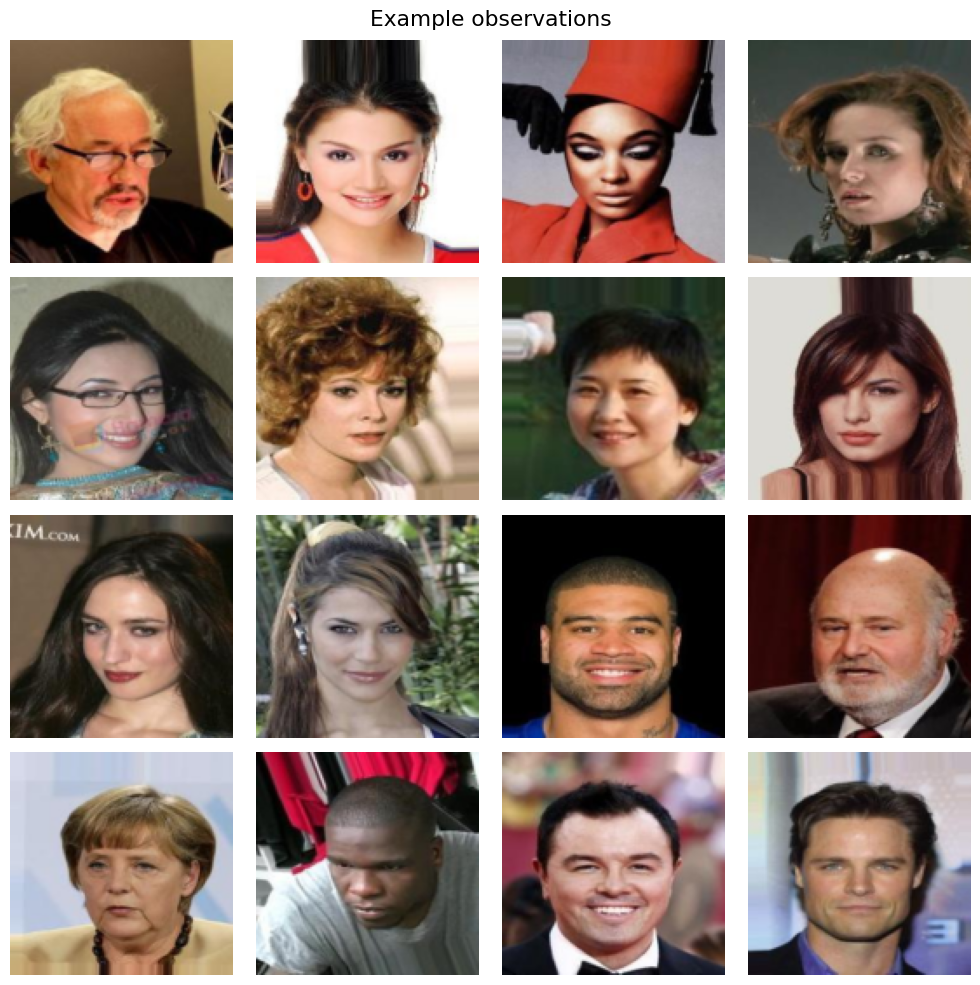

In [ ]:
plot_images(16, train_generator, fig_size = (10, 10))

In [ ]:
class Sampling(layers.Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))

    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# Encoder
encoder_input = layers.Input(
    shape=(IMG_SIZE, IMG_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(32, kernel_size=3, strides=2, padding="same")(
    encoder_input
)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(32, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 32)           896       ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)           0         ['batch_normalization[0]

In [ ]:
# Decoder
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)

x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    64, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    64, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    32, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    32, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
decoder_output = layers.Conv2DTranspose(
    3, kernel_size=3, strides=1, activation="sigmoid", padding="same"
)(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 300)]             0         
                                                                 
 dense (Dense)               (None, 2048)              616448    
                                                                 
 batch_normalization_5 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 2048)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                    

In [ ]:
class VAE(models.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)

    self.encoder = encoder
    self.decoder = decoder

    self.total_loss_tracker = metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
    self.kl_loss_tracker = metrics.Mean(name="kl_loss")

  @property
  def metrics(self):
    return [
      self.total_loss_tracker,
      self.reconstruction_loss_tracker,
      self.kl_loss_tracker,
    ]

  def call(self, inputs):
    z_mean, z_log_var, z = encoder(inputs)
    reconstruction = decoder(z)
    return z_mean, z_log_var, reconstruction

  def train_step(self, data):
    with tf.GradientTape() as tape:
      z_mean, z_log_var, reconstruction = self(data)

      reconstruction_loss = BETA * tf.reduce_mean(
        losses.binary_crossentropy(
          data, reconstruction, axis=(1, 2, 3)
        )
      )

      kl_loss = tf.reduce_mean(
        tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1)
        )

      total_loss =reconstruction_loss + kl_loss

      grads = tape.gradient(total_loss, self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

      self.total_loss_tracker.update_state(total_loss)
      self.reconstruction_loss_tracker.update_state(reconstruction_loss)
      self.kl_loss_tracker.update_state(kl_loss)

    return {m.name: m.result() for m in self.metrics}

  def test_step(self, data):
    if isinstance(data, tuple):
      data = data[0]

    z_mean, z_log_var, reconstruction = self(data)

    reconstruction_loss = BETA * tf.reduce_mean(
      losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
    )

    kl_loss = tf.reduce_mean(
      tf.reduce_sum(
        -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
        axis=1,
      )
    )

    total_loss = reconstruction_loss + kl_loss

    return {
      "loss": total_loss,
      "reconstruction_loss": reconstruction_loss,
      "kl_loss": kl_loss,
    }

  def get_config(self):
    config = super().get_config().copy()
    config.update({
      'encoder': self.encoder.get_config(),
      'decoder': self.decoder.get_config(),
      'total_loss_tracker': self.total_loss_tracker.get_config(),
      'reconstruction_loss_tracker': self.reconstruction_loss_tracker.get_config(),
      'kl_loss_tracker': self.kl_loss_tracker.get_config(),
    })
    return config

  @classmethod
  def from_config(cls, config):
    encoder = models.Sequential.from_config(config.pop('encoder'))
    decoder = models.Sequential.from_config(config.pop('decoder'))

    return cls(encoder=encoder, decoder=decoder, **config)

In [ ]:
vae = VAE(encoder, decoder)

In [ ]:
eary_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
checkpoint = callbacks.ModelCheckpoint(f'{MODEL_SAVE_PATH}/VAE_' + '{epoch:03d}.tf', verbose=1, monitor='val_loss',save_best_only=False, mode='auto', save_format='tf')
best_model_save = callbacks.ModelCheckpoint(f'{BEST_MODEL_SAVE_PATH}/best_model.tf', save_best_only=True, monitor='val_loss', mode='min', save_format='tf')

callbacks_list = [checkpoint, best_model_save, eary_stopping]

optimizer = optimizers.Adam(learning_rate=0.001)
vae.compile(optimizer=optimizer)

In [ ]:
vae.fit(
  train_generator,
  validation_data=val_generator,
  epochs=MAX_EPOCHS,
  shuffle=True,
  callbacks=callbacks_list
  )

Epoch 1/1000
10173/10174 [============================>.] - ETA: 0s - total_loss: 1096.1450 - reconstruction_loss: 1062.9351 - kl_loss: 33.2128
Epoch 1: saving model to /content/drive/MyDrive/ML_DL/FaceGeneration/Models/VAE_001.tf
10174/10174 [==============================] - 416s 40ms/step - total_loss: 1096.1462 - reconstruction_loss: 1062.9365 - kl_loss: 33.2127 - val_loss: 1037.0120 - val_reconstruction_loss: 996.1107 - val_kl_loss: 40.9013
Epoch 2/1000
10173/10174 [============================>.] - ETA: 0s - total_loss: 1075.9785 - reconstruction_loss: 1040.7192 - kl_loss: 35.2615
Epoch 2: saving model to /content/drive/MyDrive/ML_DL/FaceGeneration/Models/VAE_002.tf
10174/10174 [==============================] - 386s 38ms/step - total_loss: 1075.9811 - reconstruction_loss: 1040.7220 - kl_loss: 35.2614 - val_loss: 1160.1415 - val_reconstruction_loss: 1124.6704 - val_kl_loss: 35.4711
Epoch 3/1000
10174/10174 [==============================] - ETA: 0s - total_loss: 1073.3414 - recon

In [ ]:
def get_batch(dataset):
  iterator = iter(dataset)
  batch = next(iterator)

  return batch

In [ ]:
def plot_reconstructions(no_img, dataset, title='Example observations', fig_size=(6, 10), font_scale=1.25):
  header_size = fig_size[0] * (font_scale * 1.25)

  grid_size = int(np.ceil(np.sqrt(no_img)))

  fig, axs = plt.subplots(grid_size, grid_size, figsize=fig_size)
  axs = axs.flatten()

  for i, ax in enumerate(axs):
    if i < no_img:
      imgs = get_batch(dataset)
      z_mean, z_log_var, reconstructions = vae.predict(imgs, verbose=0)
      ax.imshow(reconstructions[0])
      ax.axis('off')
    else:
      ax.remove()

  plt.tight_layout()
  plt.subplots_adjust(top=0.95)
  plt.suptitle(title, size=header_size)
  plt.show()

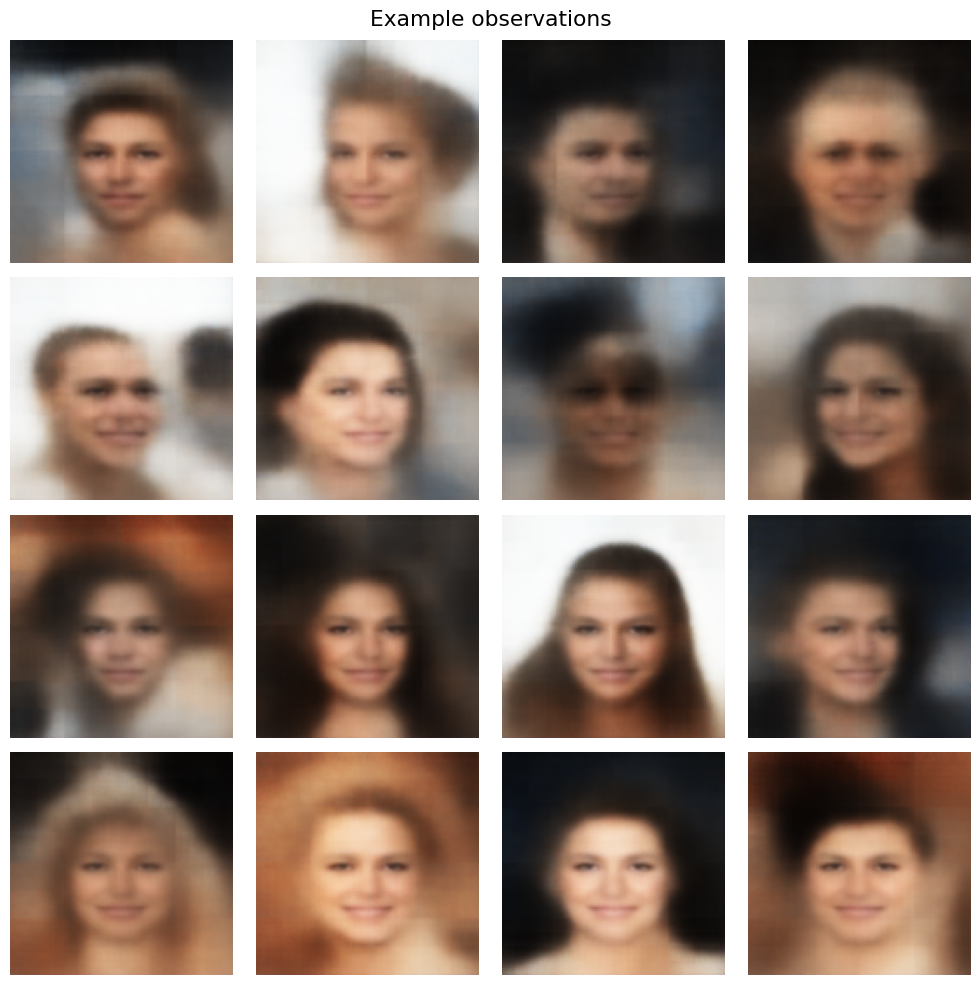

In [ ]:
plot_reconstructions(16, test_generator, fig_size = (10, 10))

In [ ]:
def plot_samples(no_img, title='Example observations', fig_size=(6, 10), font_scale=1.25):
  header_size = fig_size[0] * (font_scale * 1.25)

  grid_size = int(np.ceil(np.sqrt(no_img)))

  fig, axs = plt.subplots(grid_size, grid_size, figsize=fig_size)
  axs = axs.flatten()

  for i, ax in enumerate(axs):
    if i < no_img:
      sample = np.random.normal(size=(16, Z_DIM))
      reconstruction = decoder.predict(sample, verbose=0)
      ax.imshow(reconstruction[0])
      ax.axis('off')
    else:
      ax.remove()

  plt.tight_layout()
  plt.subplots_adjust(top=0.95)
  plt.suptitle(title, size=header_size)
  plt.show()

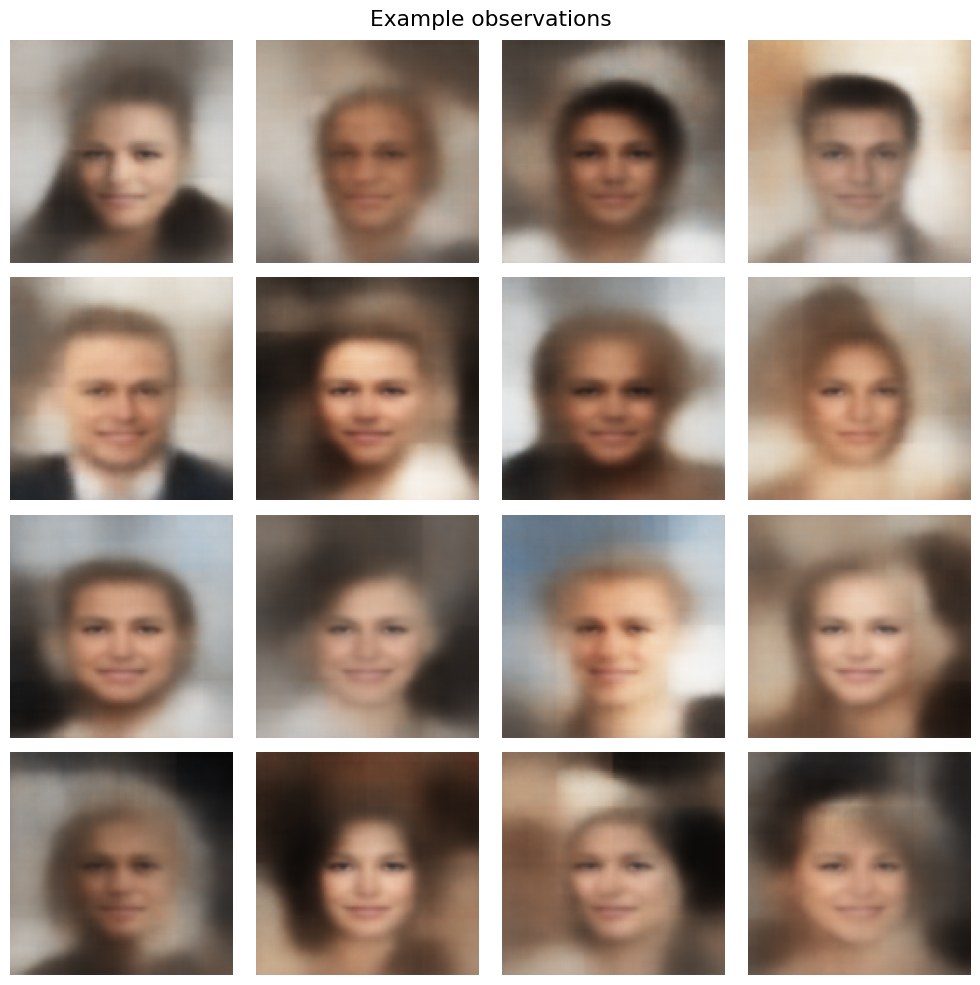

In [ ]:
plot_samples(16, fig_size = (10, 10))